In [1]:
from datetime import timedelta
import pickle
from nltk import everygrams
from nltk import FreqDist
from nltk.corpus import stopwords 
import re
import json
import math
import numpy as np
import tweepy
from nltk.stem import PorterStemmer
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd
import os
from statistics import mean 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from pylab import rcParams
from matplotlib.dates import DateFormatter

In [2]:
#Import the tweets stored in a file and remove tweets which aren't in English
x=[]
with open('24h','rb') as fp:
    x=pickle.load(fp)
for i in x:
    if i.lang!='en':
        x.remove(i)

In [3]:
#Prepare stopword list
with open('sw1.txt','r') as f:
    stop_words=f.readlines()
stop_words.append('rt') 
for i in range(len(stop_words)):
    stop_words[i]=stop_words[i].rstrip()
    

In [4]:
#Custom tokenizer function for Twitter which handles '#' and '@' differently 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 

In [16]:
#Preprocess and tokenize tweets and append them to corpus
corpus=[]
for i in range(len(x)):
    sentence=x[i].text
    sentence=sentence.replace('’',"'")
    sentence=sentence.lower()
    sentence=preprocess(sentence)
    sentence = [w for w in sentence if not w in stop_words]
    corpus.append(sentence)


        

In [17]:
#Remove tokens which aren't words or digits in the corpus
flag=1
while flag:
    flag=0
    for i in range(len(corpus)):
        for j in corpus[i]:
            if not bool(re.search('\w',j)):
                if not bool(re.search('\d',j)):
                    corpus[i].remove(j)
                    flag=1


In [18]:
#Join the tokens to form processed tweets, Uncomment the code below to implement stemming

#ps = PorterStemmer()
for i in range(len(corpus)):
    #for j in range(len(corpus[i])):
        #corpus[i][j]=ps.stem(corpus[i][j])
    corpus[i]=" ".join(corpus[i])

In [19]:
#Reading Sentiment140 scores of each tweet. Refer to http://www.sentiment140.com/
s=[]
with open('24h_140','r') as f:
    s=f.readlines()

In [20]:
"""
The entire collection of tweets is segmented by each hour. 
All ngrams in each hour is stored in ngram_list.
Tweet_list contains processed tweets for each hour. Otweet_list contains unprocessed tweets for each hour.
Sentiment_list contains sentiment for each tweet.
Time_list contains the starting time for each hour segment
"""
analyser = SentimentIntensityAnalyzer()

it=x[0].created_at
string=corpus[0]

ngrams=[]
tweets=[]
otweets=[]
sentiment=[]

ngram_list=[]
tweet_list=[]
otweet_list=[]
time_list=[]
sentiment_list=[]

tweets.append(string)
otweets.append(x[0])

for i in list(everygrams(string.split(), 2, 3)): #We consider only bi,tri grams
    ngrams.append(i)

time_list.append(x[0].created_at)


sentiment.append([analyser.polarity_scores(x[0].text),TextBlob(x[0].text).sentiment,int(s[0][1])])




for i in range(len(x[1:])):

    string=corpus[i+1]
    tweets.append(string)
    otweets.append(x[i+1])
    sentiment.append([analyser.polarity_scores(x[i+1].text),TextBlob(x[i+1].text).sentiment,int(s[i+1][1])])
    
    for j in list(everygrams(string.split(), 2, 3)): 
        ngrams.append(j)
        
    if x[i+1].created_at-it>timedelta(seconds=3600):
        it=x[i].created_at
        tweet_list.append(tweets)
        otweet_list.append(otweets)
        ngram_list.append(ngrams)
        time_list.append(it)
        sentiment_list.append(sentiment)
        ngrams=[]
        sentiment=[]
        tweets=[]
        otweets=[]

if len(ngrams)>0:
    ngram_list.append(ngrams)
    tweet_list.append(tweets)
    otweet_list.append(otweets)
    sentiment_list.append(sentiment)


In [21]:
#Find frequency distribution for the ngrams in each hour.
fdist_list=[]
for ngrams in ngram_list:
    fdist=FreqDist(ngrams)
    fdist_list.append(fdist)

In [22]:
#Calculate score from frequency list
score=dict()
score_list=[]
dict_list=[]
for j in range(len(fdist_list)-1):
    for i in list(fdist_list[j+1].keys()):
        score[i]=(fdist_list[j+1][i]+1)/(math.log10(fdist_list[j][i]+1)+1)
    dict_list.append(score)
    score=sorted((value,key) for (key,value) in score.items())
    score.reverse()
    score_list.append(score)
    score=dict()

In [23]:
"""Function to extract topics. This function takes the time segment to cluster and form topics.
The topics are written to a file named topic.txt"""
def get_topics(x1):
    score=score_list[x1][:100]
    tweets=tweet_list[x1+1]
    for i in range(len(tweets)):
        tweets[i]=list(everygrams(tweets[i].split(), 2, 3))
    s=[]
    for i in range(len(score)):
        print(i)
        ng1=score[i][1]
        for ng2 in score[i+1:]:
            cnt=0
            ng2=ng2[1]
            for k in tweets:
                if ng1 in k:
                    if ng2 in k:
                        cnt+=1
            s.append(1-cnt/(fdist_list[x1+1][ng1]+fdist_list[x1+1][ng2]-cnt))
    
    np.set_printoptions(suppress=True)
    z=linkage(s)
    
    d=dict()
    for i in range(len(score)):
        d[i]=[score[i][1]]
    
    iteration=0
    for i in z:
        if i[2]>0.5:
            break
        iteration+=1
        value=d[i[1]]
        del d[i[1]]
        for j in value:
            d[i[0]].append(j)
        d[len(score)-1+iteration]=d[i[0]]
        del d[i[0]]
    
    score2=[x[1] for x in list(d.items())]
    
    cnt=1
    while cnt:
        print(cnt)
        cnt=0
        for i in range(len(score2)):
            if len(score2[i])>1:
                for j in score2[i]:
                    for k in score2[i]:
                        if j!=k:
                            if set(j).issubset(k):
                                print(j,k)
                                score2[i].remove(j)
                                cnt+=1
                                break
    y=[]
    for i in score2:
        c=0
        for j in i:
            c+=dict_list[x1][j]
        c/=len(i)
        y.append(c)
    score2=[x for _,x in sorted(zip(y,score2))]
    score2.reverse()
    y.reverse()
    score2
    
    with open('topics.txt','a') as f: 
        f.write(str(time_list[x1+1])+'\n')
        
    for i in score2:
        with open('topics.txt','a') as f:
            for j in i:
                for k in j:
                    f.write(k+" ")
            f.write('\n')
  

In [ ]:
#Get topics for each hour
for i in range(len(score_list)):
    get_topics(i)
    


In [ ]:
"""
This stub contains code related to time performance after stemming

bla=[]
for i in range(3):
    start=time.time()
    get_topics(i)
    end=time.time()
    bla.append(end-start)


[2257.7466406822205, 3253.914880514145, 3299.5917744636536] after stemming 4336,4991,5040

[2223.3741960525513, 3128.787536382675, 3406.2456200122833] before stemming,4349,5015,5056

'2019-03-08 15:28:46'  '2019-03-08 15:51:12' 
"""


/home/adithya/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


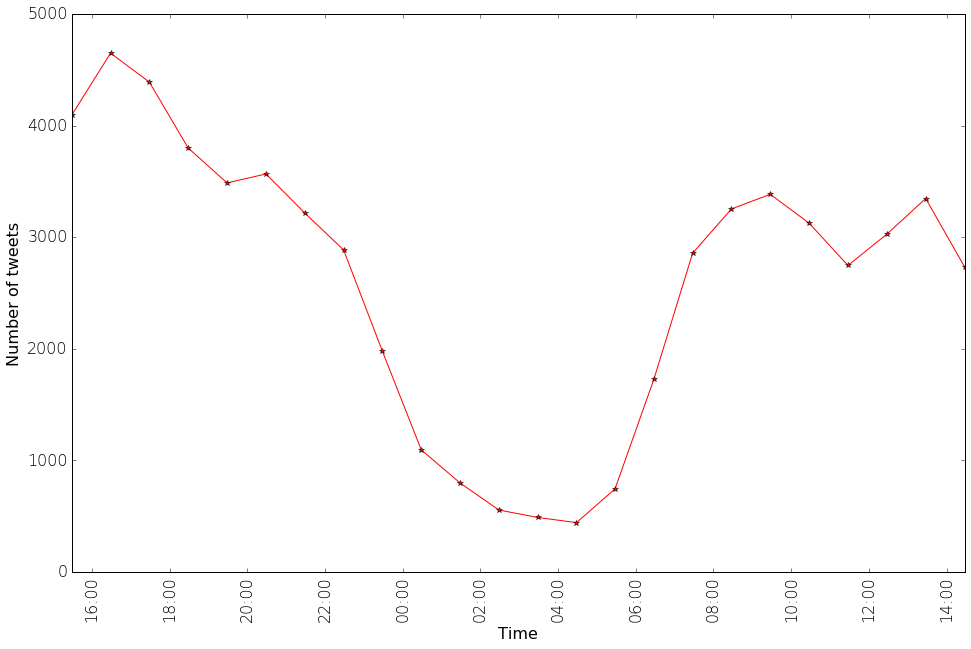

In [26]:
#The code below is to generate various graphs some of which have been used in the paper.



rcParams['figure.figsize'] = 16,10
rcParams['font.size']=16
rcParams['font.weight']=4

x1=[]
for i in otweet_list:
    x1.append(len(i))

formatter = DateFormatter('%H:%M')
    
plt.xticks(rotation=90)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Number of tweets',fontsize=16)
plt.plot(time_list,x1,color='r',marker='*')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)  
plt.savefig('index.eps',format='eps')

Text(0, 0.5, 'Average Sentiment Score')

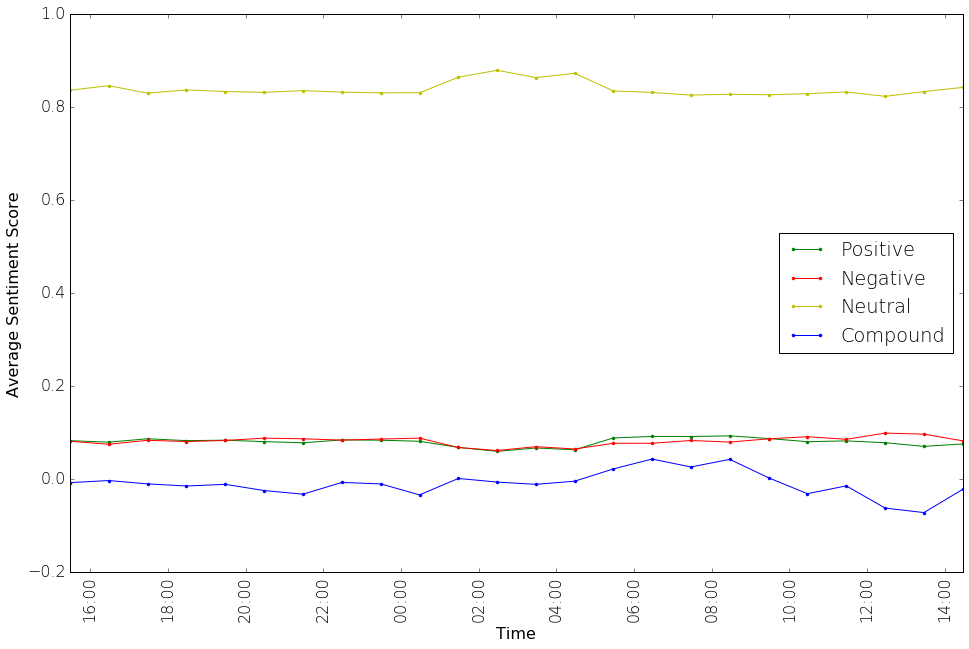

In [27]:
x1=[]
p=[]
ne=[]
nu=[]
c=[]
for i in sentiment_list:
    neg,neu,pos,comp=0,0,0,0
    for j in i:
        j=j[0]
        neg+=j['neg']
        pos+=j['pos']
        neu+=j['neu']
        comp+=j['compound']
    neg/=len(i)
    pos/=len(i)
    neu/=len(i)
    comp/=len(i)
    p.append(pos)
    ne.append(neg)
    nu.append(neu)
    c.append(comp)

    
plt.plot(time_list,p,label='Positive',color='g',marker='.')
plt.plot(time_list,ne,label='Negative',color='r',marker='.')
plt.plot(time_list,nu,label='Neutral',color='y',marker='.')
plt.plot(time_list,c,label='Compound',color='b',marker='.')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)  

plt.xticks(rotation=90)
plt.legend(loc='center right')
plt.xlabel('Time')
plt.ylabel('Average Sentiment Score')


Text(0, 0.5, 'Average Sentiment Score')

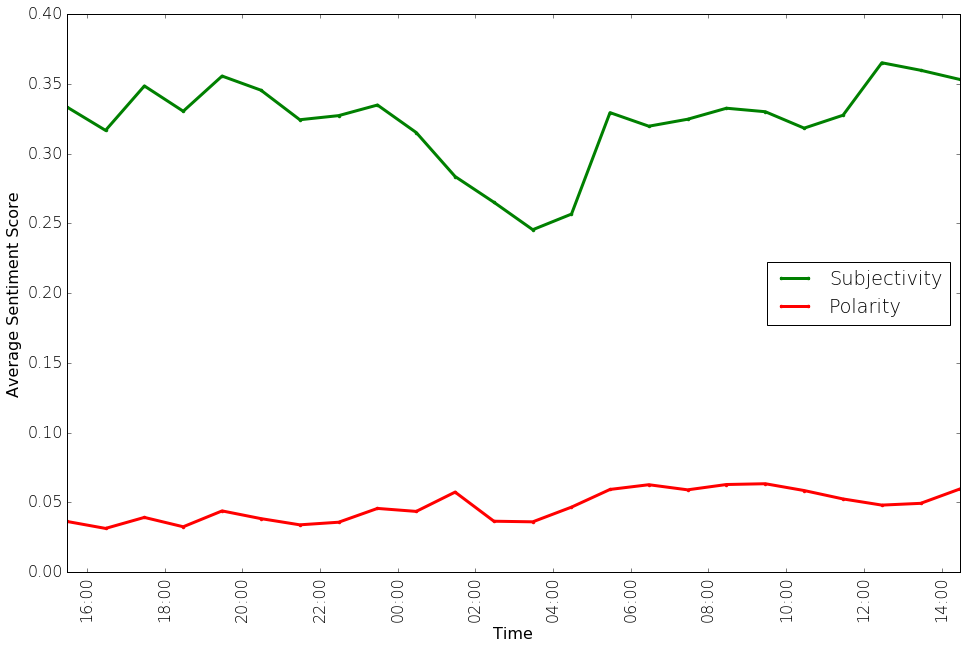

In [28]:
s=[]
p=[]
for i in sentiment_list:
    sub,pol=0,0
    for j in i:
        j=j[1]
        sub+=j[1]
        pol+=j[0]
    sub/=len(i)
    pol/=len(i)
    s.append(sub)
    p.append(pol)

    
plt.plot(time_list,s,label='Subjectivity',color='g',marker='.',linewidth=3)
plt.plot(time_list,p,label='Polarity',color='r',marker='.',linewidth=3)
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)  

plt.xticks(rotation=90)
plt.legend(loc='center right')
plt.xlabel('Time')
plt.ylabel('Average Sentiment Score')

Text(0, 0.5, 'Average Sentiment Score')

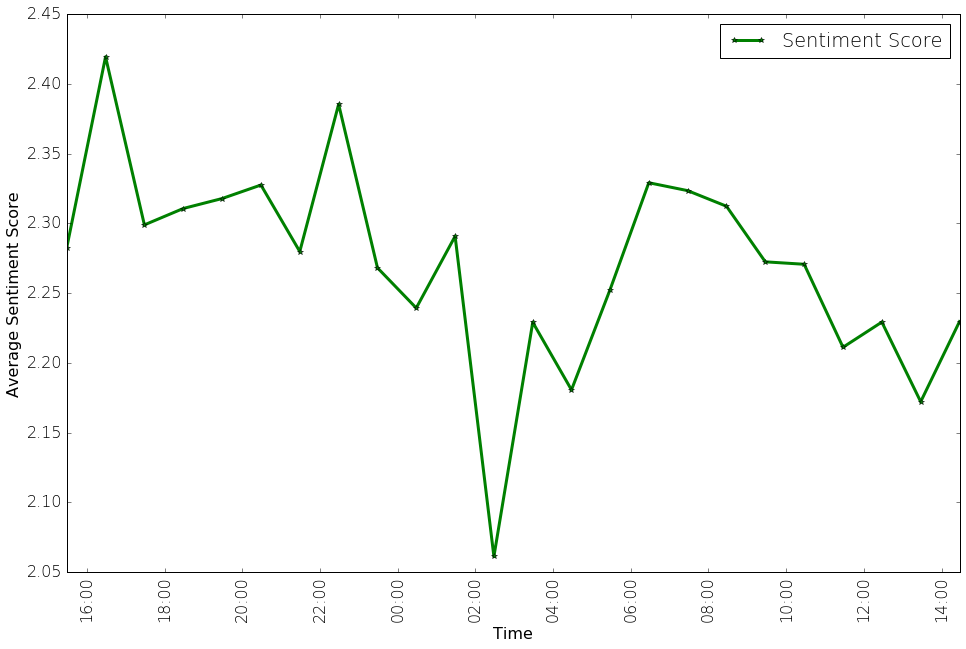

In [29]:
s=[]
for i in sentiment_list:
    score=0
    for j in i:
        j=j[2]
        score+=j
    score/=len(i)
    s.append(score)

    
plt.plot(time_list,s,label='Sentiment Score',color='g',marker='*',linewidth=3)
plt.xticks(rotation=90)
plt.legend()
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)  

plt.xlabel('Time')
plt.ylabel('Average Sentiment Score')

In [30]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [31]:
with open('topics24h') as f:
    topics=f.readlines()
try:
    for i in range(len(topics)):
        if re.search('^2019',topics[i]):
            topics.remove(topics[i])
except IndexError:
    pass

for i in range(len(topics)):
    topics[i]=topics[i].rstrip()

trending,not_trending=[],[]
for i in range(len(corpus)):
    for j in topics:
        if get_jaccard_sim(corpus[i],j)>0.2:
            trending.append(x[i])
            break
for i in x:
    if i not in trending:
        not_trending.append(i)




In [ ]:
with open('24h_tweets_in_trending.txt','w') as f:
    for i in trending:
        f.write(i.id_str+'\t'+i.user.screen_name+'\t'+i.text.replace('\n','')+'\t'+str(i.created_at)+'\n')

with open('24h_tweets_not_in_trending.txt','w') as f:
    for i in not_trending:
        f.write(i.id_str+'\t'+i.user.screen_name+'\t'+i.text.replace('\n','')+'\t'+str(i.created_at)+'\n')

Text(0.5, 1.0, 'VADER Compound Score')

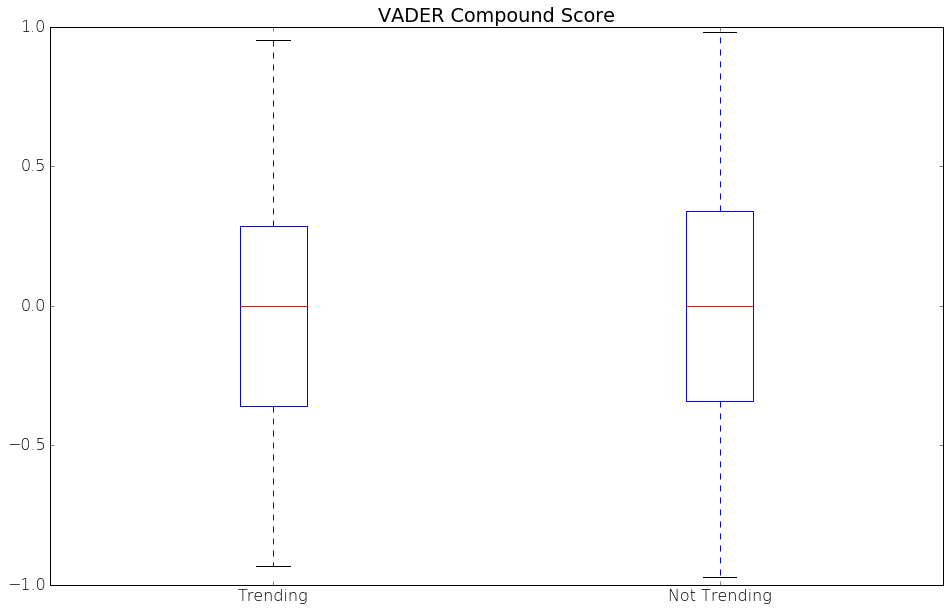

In [32]:
s=[]
for i in trending:
    s.append(analyser.polarity_scores(i.text)['compound'])
t=[]
for i in not_trending:
    t.append(analyser.polarity_scores(i.text)['compound'])
plt.boxplot([s,t],labels=['Trending','Not Trending'])
plt.title("VADER Compound Score")

Text(0.5, 1.0, 'TextBlob Polarity Score')

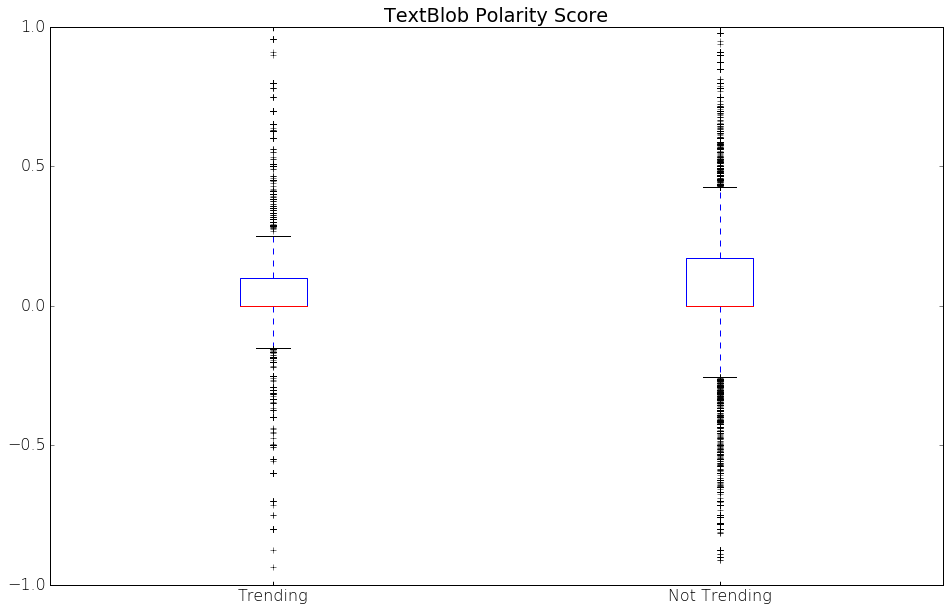

In [33]:
s=[]
for i in trending:
    s.append(TextBlob(i.text).sentiment[0])
t=[]
for i in not_trending:
    t.append(TextBlob(i.text).sentiment[0])
plt.boxplot([s,t],labels=['Trending','Not Trending'])
plt.title("TextBlob Polarity Score")

Text(0, 0.5, 'Number of Topics')

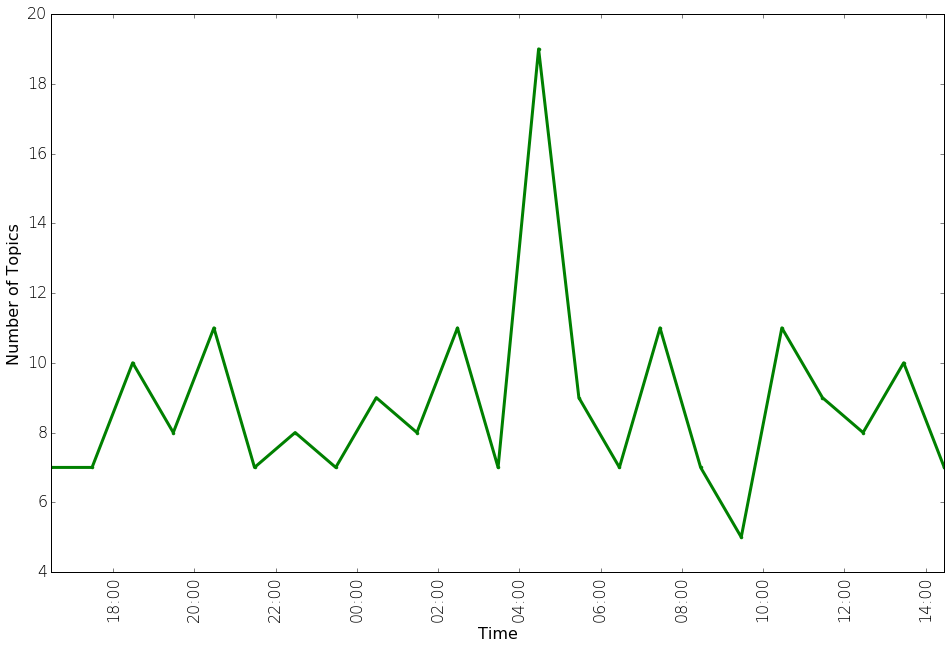

In [34]:
with open('topics24h','r') as f:
    topics=f.readlines()
for i in range(len(topics)):
    topics[i]=topics[i].rstrip()

y1=[]
sum=0
x1.append(topics[0])
for i in topics[1:]:
    sum+=1
    if re.match(r'2019',i):
        y1.append(sum-1)
        sum=0
y1.append(sum)


plt.plot(time_list[1:],y1,color='g',marker='.',linewidth=3)
plt.xticks(rotation=90)
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)  


plt.xlabel('Time')
plt.ylabel('Number of Topics')


In [35]:
#To find net sentiment score
with open('24h_140') as f:
    x1=f.readlines()
    for i in range(len(x1)):
        x1[i]=x1[i][1]
print( ( x1.count('4')-x1.count('0') )/len(x) )
p=0
n=0
p1=0
n1=0
for i in sentiment_list:
    for j in i:
        if j[0]['compound']>0.05:
            p+=1
        if j[0]['compound']<0.05:
            n+=1
        if j[1][0]>0.05:
            p1+=1
        if j[1][0]<0.05:
            n1+=1
print ((p-n)/len(x1))
print((p1-n1)/len(x1))

0.14485809067453004
-0.28367441785926056
-0.30556579432362696


In [ ]:
neg_list,neu_list,pos_list=[],[],[]

for i in sentiment_list:
    neg,neu,pos=0,0,0
    for j in i:
        j=j[0]['compound']
        if j>0.05:
            pos+=1
        elif j<-0.05:
            neg+=1
        else:
            neu+=1
    
    
    neg_list.append(neg)
    neu_list.append(neu)
    pos_list.append(pos)

for i in range(len(time_list)):
    time_list[i]=str(time_list[i])
print(time_list)
df=pd.DataFrame(data=list(zip(time_list,neg_list,neu_list,pos_list)),columns=['Time','Neg','Neu','Pos'])
df.to_csv('fs.csv')